## Rudimentary comparison of state crime rates

Due to the disparity in the amount of crime data disclosed, we look at states for which we have more data to determine whether they can be used as proxies for Massachusetts crime data. In this analysis, we use the Uniform Crime Reporting Statistics disclosed by the FBI for the crime rate per 100k population on the following categories (ignoring most violent crime categories):

* Robbery rate
* Property crime rate
* Burglary rate
* Larceny-theft rate
* Motor vehicle theft rate

Source: https://www.ucrdatatool.gov/Search/Crime/State/StatebyState.cfm

For some reason, data in this format is only available to 2014. 

Normalizing the data and performing a simple Euclidean distance between each state, we can create a distance matrix between every state and Massachusetts from 1960. 

In [1]:
import pandas as pd
import scipy
import matplotlib as plt

from scipy.spatial.distance import cdist

%matplotlib inline

states = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", 
          "Connecticut", "Delaware", "District of Columbia", "Florida", "Georgia", 
          "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", 
          "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", 
          "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", 
          "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", 
          "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", 
          "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", 
          "Washington", "West Virginia", "Wisconsin", "Wyoming"]

def load_state_ucr(file="data/FBI_crime_statistics_overall.csv"):
    state_stats = pd.DataFrame()
    for idx, state in enumerate(states):
        df = pd.read_csv(file, skiprows=(idx+1)*7 + (56*idx) + 2, nrows=56)
        df["State"] = state
        state_stats = state_stats.append(df, ignore_index=True)
    relevant_cols = ["State", "Year", "Robbery rate", "Property crime rate", 
                     "Burglary rate", "Larceny-theft rate", "Motor vehicle theft rate"]
    return state_stats[relevant_cols]
    
state_stats = load_state_ucr()

def compute_distance(year):
    x = state_stats[state_stats["Year"] == year].drop("Year", axis=1)
    x = x.set_index("State")
    normalized_x=(x-x.mean())/x.std()
    normalized_x.head()
    df = pd.DataFrame(
        cdist(normalized_x.values, normalized_x.values, 'euclidean'), 
        index=normalized_x.index, columns=normalized_x.index)[["Massachusetts"]]
    df.columns = [str(year)]
    return df

In [2]:
state_stats[state_stats["Year"] == 2014].head()

,State,Year,Robbery rate,Property crime rate,Burglary rate,Larceny-theft rate,Motor vehicle theft rate
54,Alabama,2014.0,96.9,3177.6,819.0,2149.5,209.1
110,Alaska,2014.0,85.4,2760.0,427.6,2096.4,236.0
166,Arizona,2014.0,92.8,3197.5,647.1,2289.1,261.3
222,Arkansas,2014.0,69.1,3338.0,835.7,2313.5,188.8
278,California,2014.0,125.5,2441.1,522.3,1527.4,391.3


In [3]:
distances = pd.DataFrame()
for yr in range(1990, 2015):
    series = compute_distance(yr)
    distances = pd.concat([distances, series], axis=1, sort=False)

Looking at the comparison with Maryland an Pennsylvania we can look at distances with the following chart. Lower values are better, implying they are more similar:

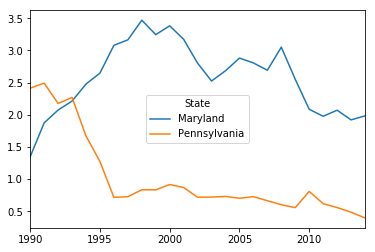

In [4]:
distances.loc[["Maryland","Pennsylvania"],:].transpose().plot();

This would seem to imply that if we were to choose between Maryland and Pennsylvania, Pennsylvania would seem to be a better proxy based on the crime rates for the given categories above. Moreover, if we look at 2014 below, it would seem Pennsylvania is actually the best choice compared to other states.

In [5]:
distances[["2014"]].sort_values(by="2014").head(10)

,2014
State,
Massachusetts,0.000000
Pennsylvania,0.395569
New Jersey,0.493097
Connecticut,0.545013
Illinois,0.657492
Wisconsin,0.717851
Virginia,0.885313
New York,0.896220
South Dakota,0.912813


If we look at the actual values for the crime rates, we can see that they are in fact pretty similar:

In [6]:
mpd = state_stats[state_stats["State"].str.contains('Massachusetts|Pennsylvania|Maryland')]
mpd[mpd["Year"] == 2014]

,State,Year,Robbery rate,Property crime rate,Burglary rate,Larceny-theft rate,Motor vehicle theft rate
1174,Maryland,2014.0,159.7,2507.5,468.7,1819.6,219.2
1230,Massachusetts,2014.0,89.5,1857.1,370.1,1364.5,122.5
2182,Pennsylvania,2014.0,105.8,1931.7,357.5,1472.2,102.0
